Time series forecasting is a hot topic which has many possible applications, such as stock prices forecasting, weather forecasting, business planning, resources allocation and many others. 

# What is a time series?

A time series is usually modelled through a stochastic process Y(t), i.e. a sequence of random variables. In a forecasting setting we find ourselves at time t and we are interested in estimating Y(t+h), using only information available at time t.

# Stage 1: Importing dependencies.

In [0]:
from google.colab import drive
#The best way to use files in Google colab is via Google Drive. So, we import drive module to connect it with Google colab

In [0]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [3]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

Using TensorFlow backend.


#Stage 2: Data preprocessing

# Loading files

Obviously, the first step is to load our files. As already told, drive is the best way of accessing files in Google Colab. The mount method of drive gives us the ability to connect one's Drive to Colab.
'/content/drive' is the path at which Drive is located

```
# This is formatted as code
```



In [4]:
#When you run this, it asks you to go to a URL for authentication. Once you land on the page, copy the code available and paste it in the textbox titled
#'Enter your authorization code' and hit enter.
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train = pd.read_csv("/content/drive/My Drive/Terra_blu/train_csv.csv")

In [119]:
train.head()

,id,time,feature
0,0,2019-03-19 00:00:00,237.97
1,1,2019-03-19 00:00:10,57.93
2,2,2019-03-19 00:00:20,90.53
3,3,2019-03-19 00:00:30,260.75
4,4,2019-03-19 00:00:40,49.70


In [120]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       80 non-null     int64  
 1   time     80 non-null     object 
 2   feature  80 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.0+ KB


In [121]:
#Converting time object to datetime
train['time']= pd.to_datetime(train['time']) 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   id       80 non-null     int64         
 1   time     80 non-null     datetime64[ns]
 2   feature  80 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.0 KB


In [122]:
train.drop('id', inplace=True, axis=1)
train.set_index(['time'], inplace=True)
train.head()

,feature
time,
2019-03-19 00:00:00,237.97
2019-03-19 00:00:10,57.93
2019-03-19 00:00:20,90.53
2019-03-19 00:00:30,260.75
2019-03-19 00:00:40,49.70


In [123]:
train.isnull().sum()

feature    0
dtype: int64

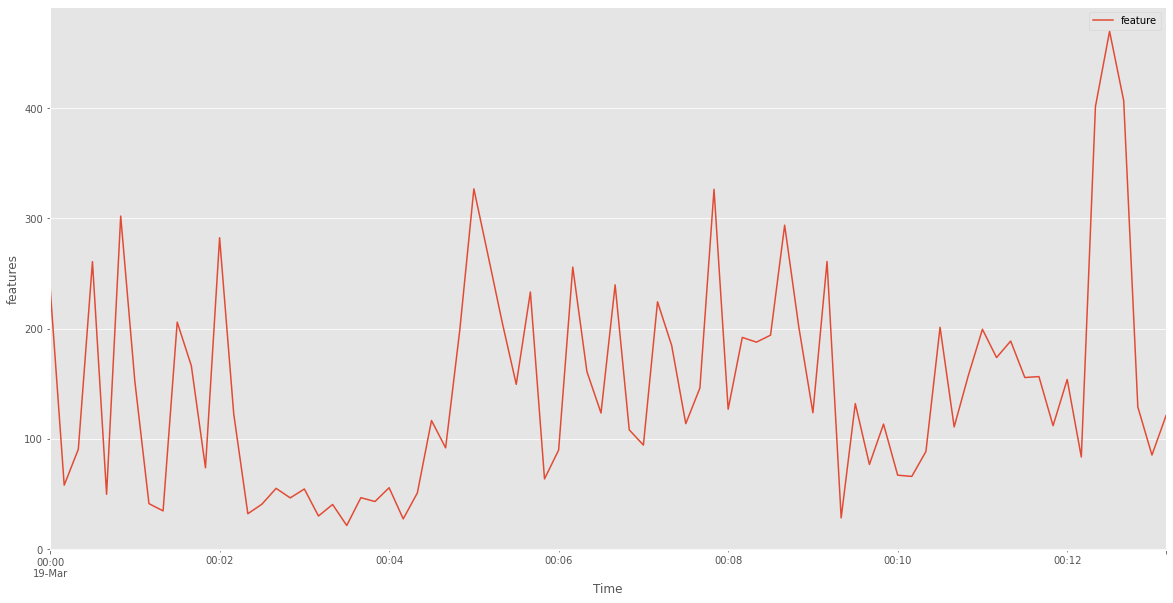

In [124]:
# Plot the data
train.plot()
plt.ylabel('features')
plt.xlabel('Time')
plt.show()



Some distinguishable patterns appear when we plot the data. There is always a strong upward trend within any single Day with a couple of High Values in the last minutes.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.


In [125]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train, model='additive', freq = 2)
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

                      feature
time                         
2019-03-19 00:00:00       NaN
2019-03-19 00:00:10  111.0900
2019-03-19 00:00:20  124.9350
2019-03-19 00:00:30  165.4325
2019-03-19 00:00:40  165.5575
...                       ...
2019-03-19 00:12:30  436.9150
2019-03-19 00:12:40  353.0525
2019-03-19 00:12:50  187.4725
2019-03-19 00:13:00  105.1475
2019-03-19 00:13:10       NaN

[80 rows x 1 columns]
                      feature
time                         
2019-03-19 00:00:00 -3.325192
2019-03-19 00:00:10  3.325192
2019-03-19 00:00:20 -3.325192
2019-03-19 00:00:30  3.325192
2019-03-19 00:00:40 -3.325192
...                       ...
2019-03-19 00:12:30  3.325192
2019-03-19 00:12:40 -3.325192
2019-03-19 00:12:50  3.325192
2019-03-19 00:13:00 -3.325192
2019-03-19 00:13:10  3.325192

[80 rows x 1 columns]
                        feature
time                           
2019-03-19 00:00:00         NaN
2019-03-19 00:00:10  -56.485192
2019-03-19 00:00:20  -31.079808
2019-03-19 00:

In [126]:
df_reconstructed = pd.concat([result.seasonal, result.trend, result.resid, result.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.tail(20)

,seas,trend,resid,actual_values
time,,,,
2019-03-19 00:10:00,-3.325192,78.3150,-7.979808,67.01
2019-03-19 00:10:10,3.325192,71.8150,-9.250192,65.89
2019-03-19 00:10:20,-3.325192,111.0000,-19.204808,88.47
2019-03-19 00:10:30,3.325192,150.4000,47.444808,201.17
2019-03-19 00:10:40,-3.325192,145.0300,-30.914808,110.79
2019-03-19 00:10:50,3.325192,156.2250,-2.180192,157.37
2019-03-19 00:11:00,-3.325192,182.4575,20.237692,199.37
2019-03-19 00:11:10,3.325192,183.8750,-13.480192,173.72
2019-03-19 00:11:20,-3.325192,176.6800,15.335192,188.69


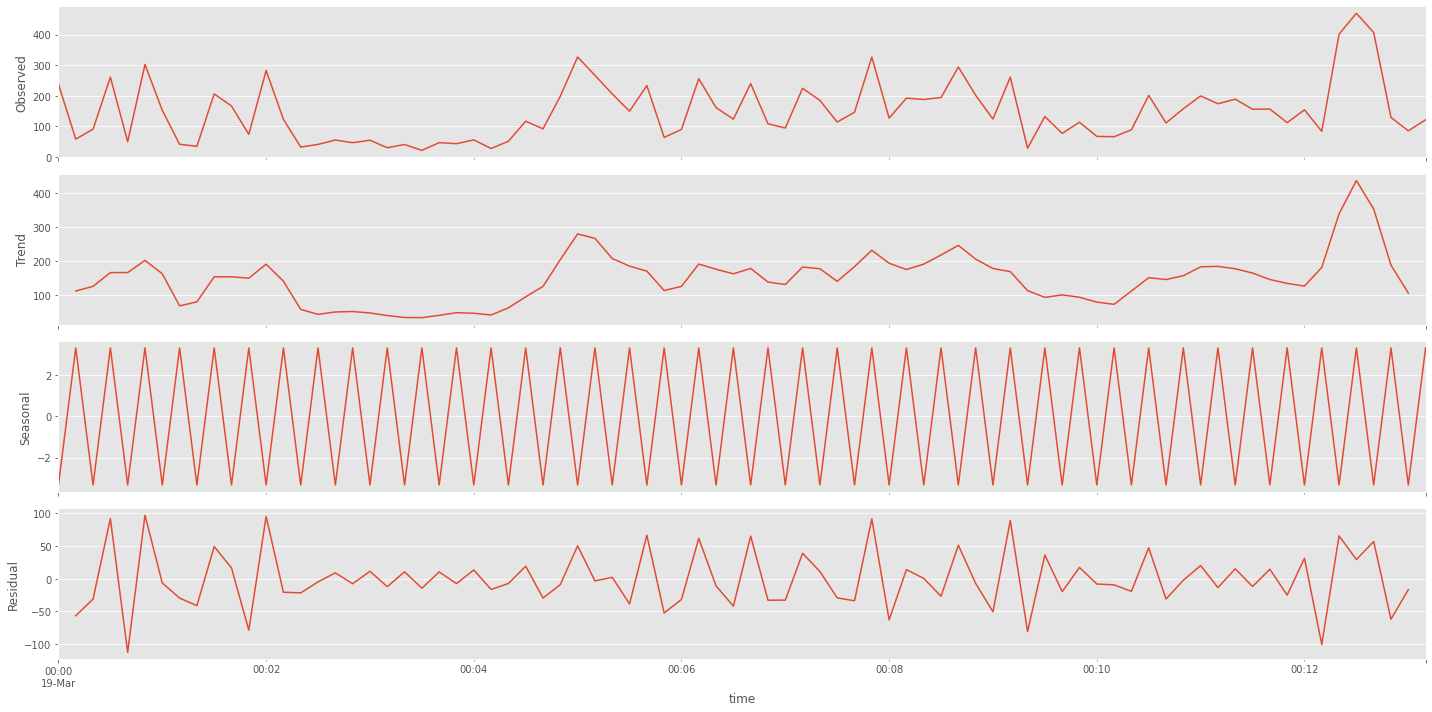

In [127]:
result.plot();

In [128]:
df_reconstructed.dropna(axis=0,inplace=True)
df_reconstructed

,seas,trend,resid,actual_values
time,,,,
2019-03-19 00:00:10,3.325192,111.0900,-56.485192,57.93
2019-03-19 00:00:20,-3.325192,124.9350,-31.079808,90.53
2019-03-19 00:00:30,3.325192,165.4325,91.992308,260.75
2019-03-19 00:00:40,-3.325192,165.5575,-112.532308,49.70
2019-03-19 00:00:50,3.325192,201.5275,97.227308,302.08
...,...,...,...,...
2019-03-19 00:12:20,-3.325192,339.0225,65.732692,401.43
2019-03-19 00:12:30,3.325192,436.9150,29.479808,469.72
2019-03-19 00:12:40,-3.325192,353.0525,57.062692,406.79


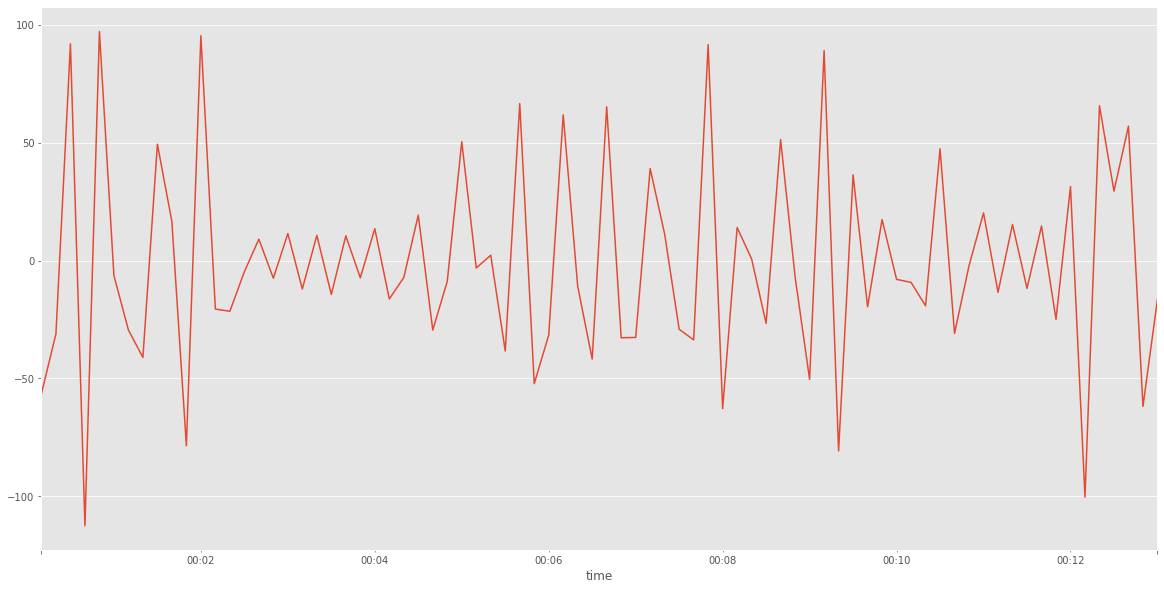

In [129]:
df_reconstructed.resid.plot()

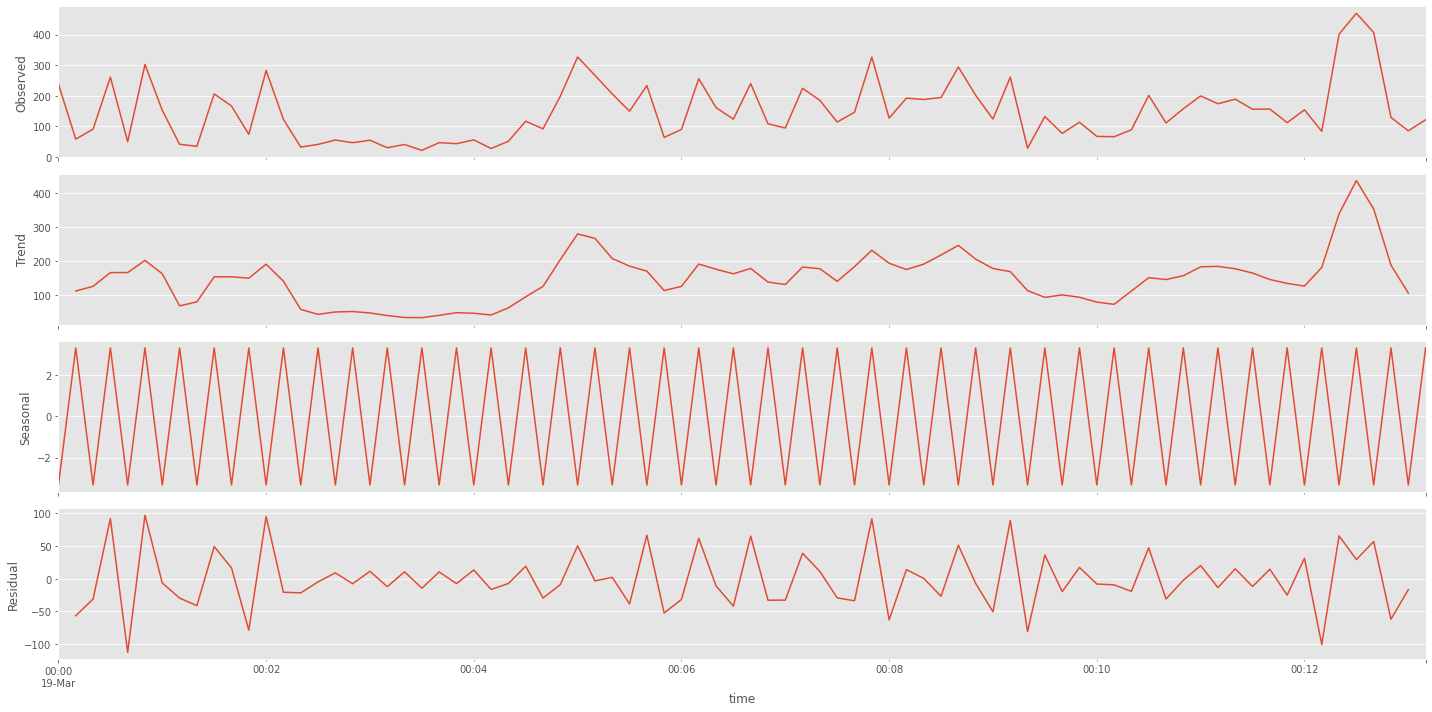

In [130]:
decomposition = sm.tsa.seasonal_decompose(train, model='additive',freq=2)
fig = decomposition.plot()
plt.show()

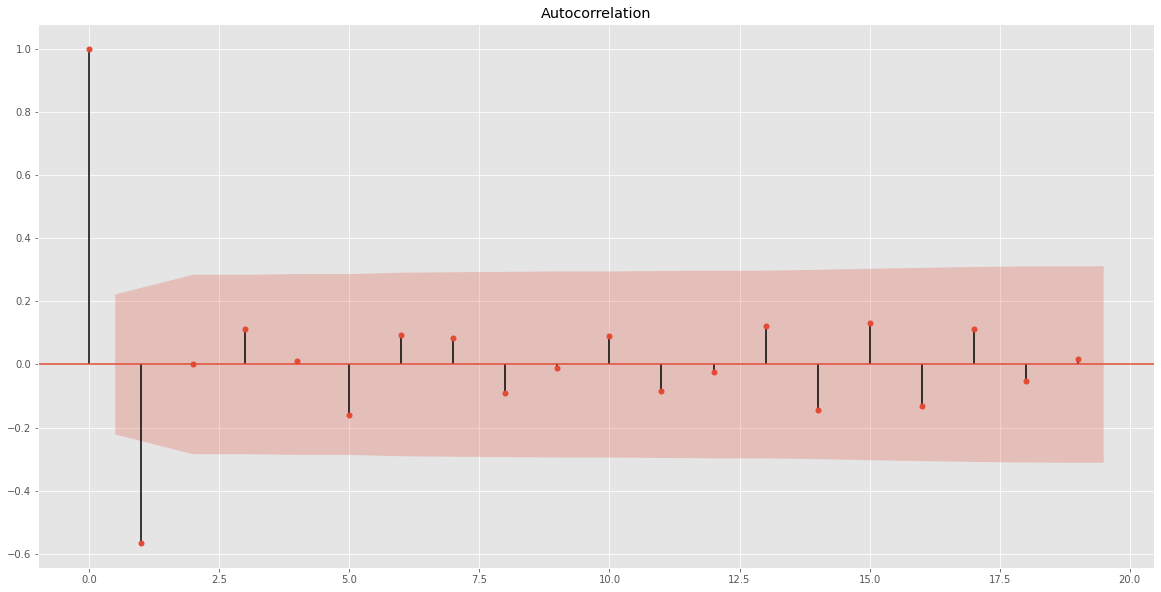

In [131]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df_reconstructed.resid.values)
pyplot.show()

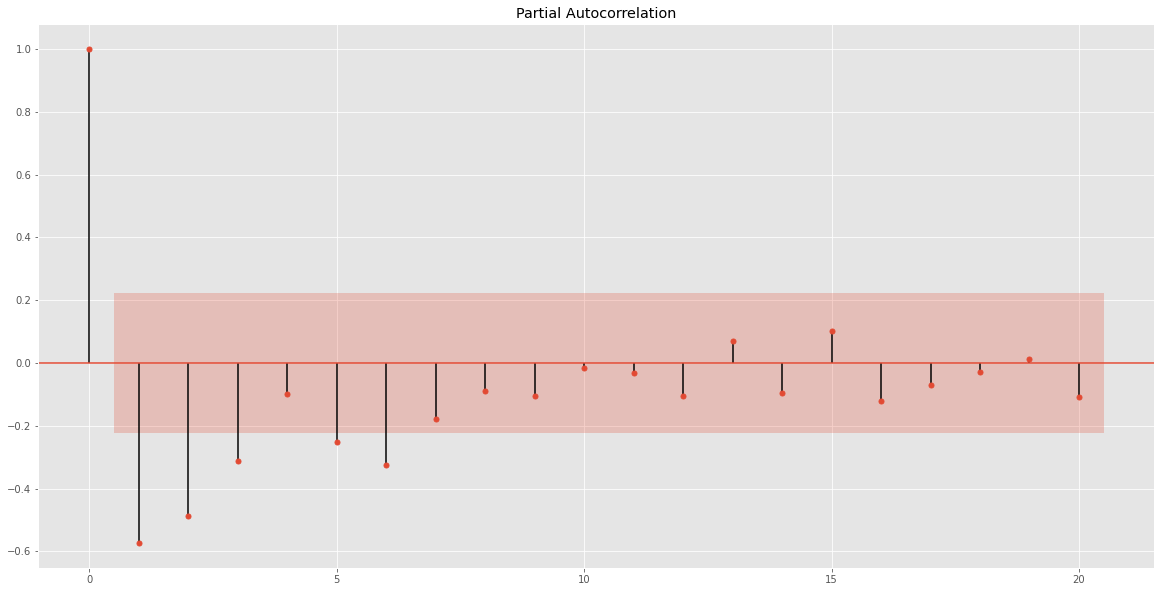

In [132]:
plot_pacf(df_reconstructed.resid, lags=20)
pyplot.show()

In [133]:
from statsmodels.tsa.stattools import adfuller, kpss
# ADF Test
adfinput = adfuller(train['feature'])
adftest = pd.Series(adfinput[0:4], index=['Dickey Fuller Statistical Test', 'P-value',
                                          'Used Lags', 'Number of comments used'])
adftest = round(adftest,4)
    
for key, value in adfinput[4].items():
    adftest["Critical Value (%s)"%key] = value.round(4) 
adftest

Dickey Fuller Statistical Test    -5.9459
P-value                            0.0000
Used Lags                          0.0000
Number of comments used           79.0000
Critical Value (1%)               -3.5160
Critical Value (5%)               -2.8989
Critical Value (10%)              -2.5867
dtype: float64

In [134]:
#Kpss
kpss_input = kpss(train['feature'])
kpss_test = pd.Series(kpss_input[0:3], index=['Statistical Test KPSS', 'P-Value', 'Used Lags'])
kpss_test = round(kpss_test,4)
    
for key, value in kpss_input[3].items():
    kpss_test["Critical Value (%s)"%key] = value 
kpss_test

Statistical Test KPSS     0.2827
P-Value                   0.1000
Used Lags                12.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
dtype: float64

In [160]:
train_data = train['2019-03-19 00:00:00':'2019-03-19 00:10:00']
train_data

,feature
time,
2019-03-19 00:00:00,237.97
2019-03-19 00:00:10,57.93
2019-03-19 00:00:20,90.53
2019-03-19 00:00:30,260.75
2019-03-19 00:00:40,49.70
...,...
2019-03-19 00:09:20,28.26
2019-03-19 00:09:30,131.97
2019-03-19 00:09:40,76.73


In [0]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()

In [137]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.feature   No. Observations:                   79
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -467.920
Method:                       css-mle   S.D. of innovations             88.305
Date:                Thu, 11 Jun 2020   AIC                            943.839
Time:                        22:35:40   BIC                            953.317
Sample:                    03-19-2019   HQIC                           947.637
                         - 03-19-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.0284      0.637      1.613      0.111      -0.221       2.278
ar.L1.D.feature     0.3403      0.109      3.121      0.003       0.127       0.554
ma.L1.D.feature    -0.9999      0.038    -26.375      0.000      -1.074      -0.926
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.9384           +0.0000j            2.9384            0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

# ARIMA
ARIMA stands for Auto-Regressive Integrated Moving Average. There are three  integers (p, d, q) that are used to parametrize ARIMA models. Because of that, a nonseasonal ARIMA model is denoted with ARIMA(p, d, q): 
<ul>
<li><strong>p</strong> is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.</li>
<li><strong>d</strong> is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.</li>
<li><strong>q</strong> is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.</li>
</ul>

When dealing with seasonal effects, as in our example, seasonal ARIMA is used, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the nonseasonal parameters described above, (<strong>P, D, Q</strong>) follow the same definition but are applied to the seasonal component of the time series. The term <strong>s</strong> is the periodicity of the time series.

While in this case it is clear that s=12, how do we set the other parameters? 

It is pretty much based on experience. There are numerous best practices that can be followed to identify ARIMA models.

Here we use grid search over all possible combinations of parameter values within a predefined range of values (heavily inspired by https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3). 

$statsmodels.tsa.statespace.sarimax.SARIMAXResults$ returns values for AIC (Akaike Information Criterion) and BIC (Bayes Information Criterion) that can be minimized to select the best fitting model. We use the AIC value, which estimates the information lost when a given model is used to represent the process that generates the data. In doing so, it deals with the trade-off between the goodness of fit of the model and the complexity of the model itself.

In [162]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [163]:
#warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data['feature'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [164]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 429.175070551765 for model SARIMAX(1, 0, 1)x(1, 1, 1, 12)


In [166]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data['feature'],
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7196      0.252      2.857      0.004       0.226       1.213
ma.L1         -0.3215      0.353     -0.911      0.362      -1.013       0.370
ar.S.L12      -0.7303      0.258     -2.828      0.005      -1.236      -0.224
ma.S.L12       0.6146      0.644      0.954      0.340      -0.648       1.877
sigma2      8159.3631   4088.626      1.996      0.046     145.803    1.62e+04


Once the model has been fitted, we can check if does what we expect and if the assumptions we made are violated. To do this, we can use the  𝑝𝑙𝑜𝑡_𝑑𝑖𝑎𝑔𝑛𝑜𝑠𝑡𝑖𝑐𝑠  method.

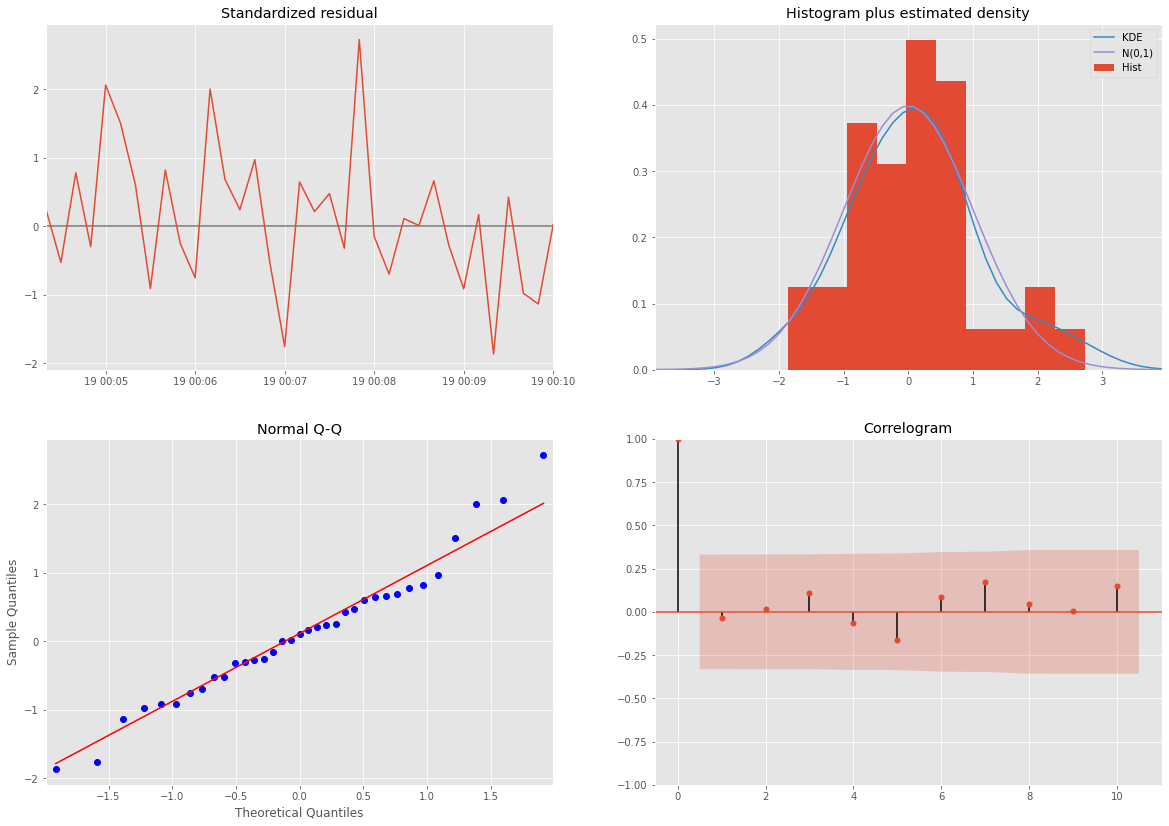

In [167]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In the plots above, we can observe that the residuals are uncorrelated (bottom right plot) and do not exhibit any obvious seasonality (the top left plot). Also, the residuals are roughly normally distributed (top right plot). The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.



# Results
Now let's create some predictions. We will use three methods:

1) In sample prediction with 1-step ahead forecasting at 2019-03-19 00:10:00. In this case the model is used to predict data that the model was built on. 1-step ahead forecasting implies that each forecasted point is used to predict the following one.

In [0]:
pred0 = results.get_prediction(start=pd.to_datetime('2019-03-19 00:10:00'), dynamic=False)
pred0_ci = pred0.conf_int()

2) In sample prediction with dynamic forecasting at 2019-03-19 00:10:00. Again, the model is used to predict data that the model was built on.

In [0]:
pred1 = results.get_prediction(start=pd.to_datetime('2019-03-19 00:10:00'), dynamic=True)
pred1_ci = pred1.conf_int()

3) "True" forecasting of out of sample data. In this case the model is asked to predict data it has not seen before.

In [170]:
pred2 = results.get_forecast(pd.to_datetime('2019-03-19 00:20:00'))
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean[pd.to_datetime('2019-03-19 00:10:00'):pd.to_datetime('2019-03-19 00:20:00')])

2019-03-19 00:10:10    178.684057
2019-03-19 00:10:20    143.400730
2019-03-19 00:10:30    123.074347
2019-03-19 00:10:40    276.205527
2019-03-19 00:10:50    122.253138
2019-03-19 00:11:00     49.061642
2019-03-19 00:11:10    221.017766
2019-03-19 00:11:20     28.165049
2019-03-19 00:11:30     92.093028
2019-03-19 00:11:40     47.163453
2019-03-19 00:11:50    166.297396
2019-03-19 00:12:00     58.092730
2019-03-19 00:12:10    150.158850
2019-03-19 00:12:20    148.224989
2019-03-19 00:12:30    155.089008
2019-03-19 00:12:40    274.828528
2019-03-19 00:12:50    169.894467
2019-03-19 00:13:00     96.162513
2019-03-19 00:13:10    244.807582
2019-03-19 00:13:20     24.411429
2019-03-19 00:13:30    118.462155
2019-03-19 00:13:40     66.774693
2019-03-19 00:13:50    126.207704
2019-03-19 00:14:00     63.579305
2019-03-19 00:14:10    170.251623
2019-03-19 00:14:20    144.171098
2019-03-19 00:14:30    131.328126
2019-03-19 00:14:40    275.559113
2019-03-19 00:14:50    134.906395
2019-03-19 00:

Let's plot all this

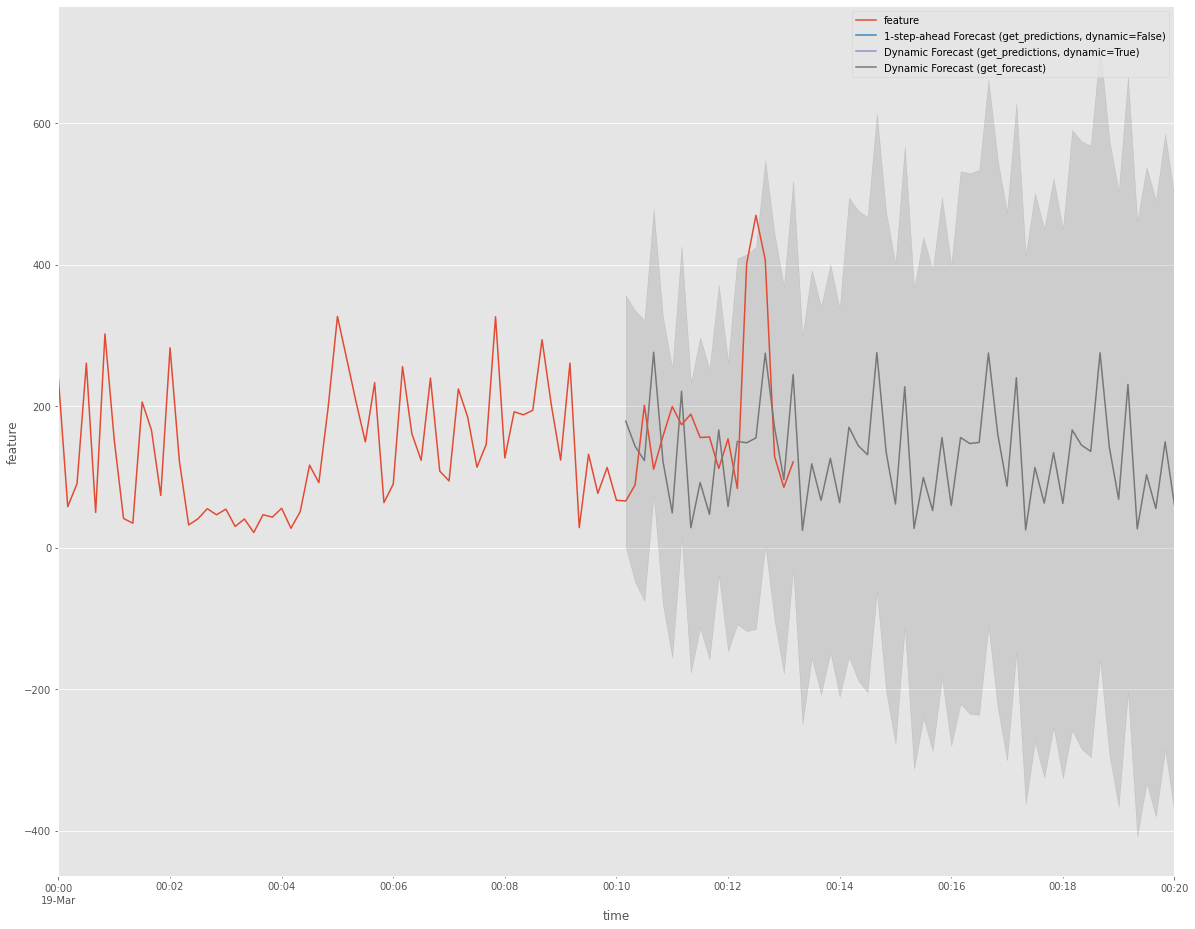

In [172]:
ax = train.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('feature')
plt.xlabel('time')
plt.legend()
plt.show()

In [0]:
test = pd.read_csv("/content/drive/My Drive/Terra_blu/test_csv.csv")

In [0]:
#Converting time object to datetime
test['time']= pd.to_datetime(test['time']) 

In [183]:
prediction = pred2.predicted_mean
# flatten nested list
truth = train['feature']['2019-03-19 00:10:00':]
#truth = list(itertools.chain.from_iterable(test.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast is 65.36%


In [184]:
y_forecasted = pred2.predicted_mean
y_truth = train['feature']['2019-03-19 00:10:00':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 17431.34


In [185]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 132.03


In [0]:
# Converting y_pred to a dataframe which is an array
ytest= pd.DataFrame(pred2.predicted_mean)

In [0]:
#Reset Index
ytest = ytest.reset_index(drop=True)

In [0]:
#Adding two Dataframes
test_pred = pd.concat([test, ytest], axis=1)

In [181]:
test_pred.head()

,id,time,0
0,80.0,2019-03-19 00:13:20,178.684057
1,81.0,2019-03-19 00:13:30,143.400730
2,82.0,2019-03-19 00:13:40,123.074347
3,83.0,2019-03-19 00:13:50,276.205527
4,84.0,2019-03-19 00:14:00,122.253138


In [182]:
#Adding column name
#test_pred['feature']=test_pred[0]
test_pred.rename(columns={'0' : 'feature'}, inplace = True)
test_pred.head()

,id,time,0
0,80.0,2019-03-19 00:13:20,178.684057
1,81.0,2019-03-19 00:13:30,143.400730
2,82.0,2019-03-19 00:13:40,123.074347
3,83.0,2019-03-19 00:13:50,276.205527
4,84.0,2019-03-19 00:14:00,122.253138
